In [1]:
import pandas as pd
import seaborn as sns
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, SimpleRNN, Embedding, LSTM, GRU, Dropout
from tensorflow.keras.models import Sequential

from utility import execute_grid_search, test_rnn_model
from keras.api.callbacks import EarlyStopping

# defining parameters
num_words = 3000  #this means we can consider only the top  3,000 most frequent words


/Users/joe_codes/dev/school/final_report_rcc_cnn/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Data preparation 
- import data and examine the data
- Remove inconsistencies, irrelevant information
- Correct inconsistent formating

In [2]:
email_datasets = pd.read_csv('test_data.csv')

email_datasets.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [3]:
print(email_datasets.head())
print(email_datasets.isnull().sum())

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
Category    0
Message     0
dtype: int64


In [4]:
# rename Category to category & Message to message for consistency between labels features

email_datasets.columns = ['category', 'message']

print(email_datasets.head())

  category                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


In [5]:
# converting  all spam to ham and all upper case to lower case in the texts so that preprocessing can occur correctly

email_datasets.category = email_datasets.category.apply(lambda x: 1 if x == 'spam' else 0)
email_datasets.message = email_datasets.message.apply(lambda x: x.lower())
print(email_datasets.head())

   category                                            message
0         0  go until jurong point, crazy.. available only ...
1         0                      ok lar... joking wif u oni...
2         1  free entry in 2 a wkly comp to win fa cup fina...
3         0  u dun say so early hor... u c already then say...
4         0  nah i don't think he goes to usf, he lives aro...


In [6]:
# the next step is preprocessing and Tokenizing the data
# this step Convert text into a sequence of tokens (numerical format) that the model can understand 

tokenizer = Tokenizer(num_words)

# Updates internal vocabulary with the words in the sequence memory
tokenizer.fit_on_texts(email_datasets.message) 

# here we are converting to a sequence of numbers
dataset_sequence = tokenizer.texts_to_sequences(email_datasets.message)


<Axes: ylabel='Count'>

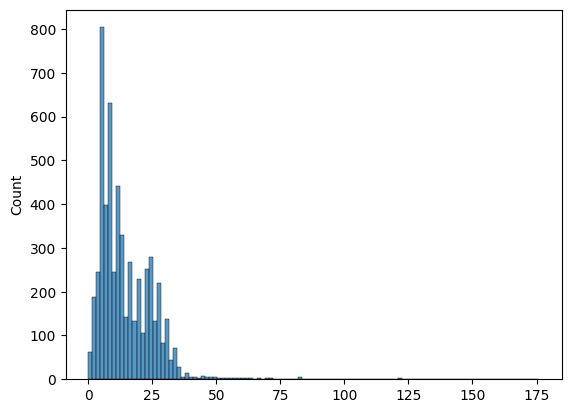

In [7]:
# determining how to pad the letters so input will be equal
# since I have chosen to find the most common highest value, with that value all sequence not up to that length will be padded
sequence_lengths = [len(seq) for seq in dataset_sequence]

sns.histplot(sequence_lengths, label='Message')

# since the majority of the sequence length words falls within 10 we will pad all the sequences less than 10 

In [8]:
padded_sequences = pad_sequences(dataset_sequence, maxlen=20)


Training

we now have the data in the right format, we can now split the data into training and testing set and since we will be using RNN we will be creating a function that will tune the model so we can take the best selection of hyperparameters, although this will be expensive in terms of time, but it will give us the best combination of hyperparameters that leads to the best model for this problem.

In [9]:
# split data into training and testing set using a ratio of 80:20
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, email_datasets.category, test_size=0.2)

## Base Model selection

In [10]:
# choosing combination of hyperparameters
# explanation of parameters 

# num of words
# output_dim 
# epochs
# batch_size
# validation_split
# activation_function
# optimizer

# embedding\_dim & rnn\_units & rnn\_type & optimizer & activation & accuracy & loss & precision & recall \\
# 100 & 64 & SimpleRNN & rmsprop & relu &  0.987444 & 0.061306 & 0.992701 & 0.912752 \\
# 50 & 64 & LSTM & rmsprop & relu & 0.982960 & 0.080875 & 0.949367 & 0.931677 \ \
# 200 & 32 & GRU & rmsprop & relu & 0.4 & 0.991031 & 0.049673 & 0.993151 & 0.941558 \\


def lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=num_words, output_dim=50))
    model.add(LSTM(32))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    # model.add(GRU(64, return_sequences = False))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model  


def gru_model():
    model = Sequential()
    model.add(Embedding(input_dim=num_words, output_dim=128))
    model.add(GRU(128))
    # model.add(GRU(64, return_sequences = False))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    return model



def simple_rnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=num_words, output_dim=50))
    model.add(SimpleRNN(32))
    # model.add(GRU(64, return_sequences = False))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

gru_model_ = gru_model()
simple_rnn_model_ = simple_rnn_model()
lstm_model_ = lstm_model()


gru_model_.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])
# Display the model summary
gru_model_.summary()
# Train the model
gru_history = gru_model_.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=3)])


simple_rnn_model_.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])
# Display the model summary
simple_rnn_model_.summary()
# Train the model
simple_history = simple_rnn_model_.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=3)])


lstm_model_.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])
# Display the model summary
lstm_model_.summary()
# Train the model
lstm_history = lstm_model_.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=3)])



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6874 - loss: 0.5413 - precision: 0.3098 - recall: 0.5979 - val_accuracy: 0.9809 - val_loss: 0.0768 - val_precision: 1.0000 - val_recall: 0.8534
Epoch 2/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9836 - loss: 0.0703 - precision: 0.9754 - recall: 0.8948 - val_accuracy: 0.9865 - val_loss: 0.0443 - val_precision: 0.9727 - val_recall: 0.9224
Epoch 3/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9913 - loss: 0.0391 - precision: 0.9948 - recall: 0.9369 - val_accuracy: 0.9910 - val_loss: 0.0386 - val_precision: 0.9909 - val_recall: 0.9397
Epoch 4/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9902 - loss: 0.0396 - precision: 0.9853 - recall: 0.9391 - val_accuracy: 0.9910 - val_loss: 0.0363 - val_precision: 0.9909 - val_recall: 0.9397
Epoch 5/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9936 - loss: 0.0259 - precision: 0.9952 - recall: 0.9554 - val_accuracy: 0.9888 - val_loss: 0.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8862 - loss: 0.3084 - precision: 0.6563 - recall: 0.5041 - val_accuracy: 0.9742 - val_loss: 0.0822 - val_precision: 0.9794 - val_recall: 0.8190
Epoch 2/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9766 - loss: 0.0838 - precision: 0.9619 - recall: 0.8633 - val_accuracy: 0.9865 - val_loss: 0.0574 - val_precision: 0.9906 - val_recall: 0.9052
Epoch 3/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9901 - loss: 0.0353 - precision: 0.9744 - recall: 0.9476 - val_accuracy: 0.9877 - val_loss: 0.0469 - val_precision: 0.9907 - val_recall: 0.9138
Epoch 4/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0274 - precision: 0.9959 - recall: 0.9454 - val_accuracy: 0.9843 - val_loss: 0.0514 - val_precision: 1.0000 - val_recall: 0.8793
Epoch 5/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0098 - precision: 0.9976 - recall: 0.9842 - val_accuracy: 0.9865 - val_loss: 0.0477 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8717 - loss: 0.3511 - precision: 0.5405 - recall: 0.2148 - val_accuracy: 0.9854 - val_loss: 0.0560 - val_precision: 0.9725 - val_recall: 0.9138
Epoch 2/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9825 - loss: 0.0630 - precision: 0.9516 - recall: 0.9130 - val_accuracy: 0.9865 - val_loss: 0.0459 - val_precision: 1.0000 - val_recall: 0.8966
Epoch 3/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9878 - loss: 0.0452 - precision: 0.9860 - recall: 0.9229 - val_accuracy: 0.9888 - val_loss: 0.0442 - val_precision: 1.0000 - val_recall: 0.9138
Epoch 4/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9890 - loss: 0.0436 - precision: 0.9891 - recall: 0.9301 - val_accuracy: 0.9888 - val_loss: 0.0364 - val_precision: 0.9818 - val_recall: 0.9310
Epoch 5/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9918 - loss: 0.0339 - precision: 0.9906 - recall: 0.9509 - val_accuracy: 0.9877 - val_loss: 0.0373 

In [ ]:
simple_result = simple_rnn_model_.evaluate(x_train, x_train)
print(f'simple_model Loss: {simple_result.loss}, Accuracy: {simple_result.accuracy}, Precision: {simple_result.precision}, Recall: {simple_result.recall}')

gru_result = gru_model_.evaluate(x_train, y_train)
print(f'gru_model Loss: {gru_result.loss}, Accuracy: {gru_result.accuracy}, Precision: {gru_result.precision}, Recall: {gru_result.recall}')

lstm_result = lstm_model_.evaluate(x_train, y_train)
print(f'lstm Loss: {lstm_result.lstmloss}, Accuracy: {lstm_result.accuracy}, Precision: {lstm_result.precision}, Recall: {lstm_result.recall}')


### Model Evaluation

- GRU model
- LSTM model
- Simple RNN model

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


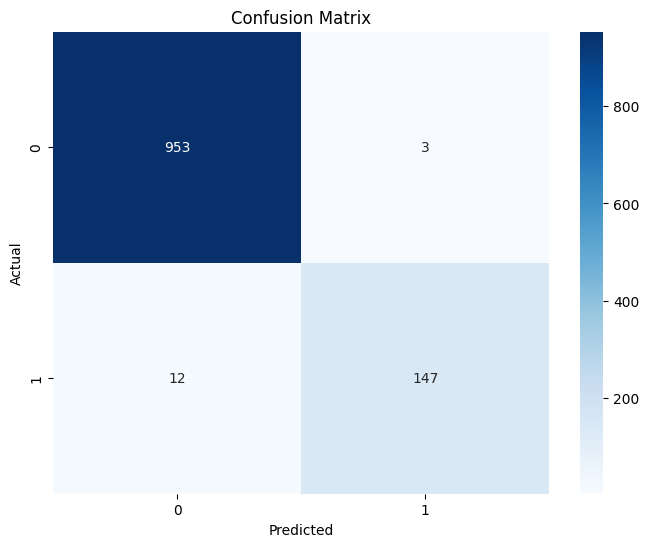

GRU Model: F1 Score: 0.9514563106796117, Precision: 0.98, Recall: 0.9245283018867925, Accuracy: 0.9865470852017937


In [11]:
## GRU model 
test_rnn_model(gru_model_, x_test, y_test)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


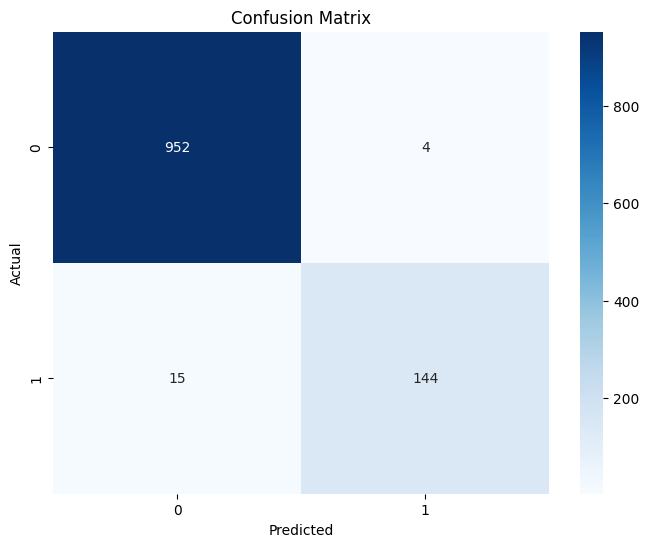

GRU Model: F1 Score: 0.9381107491856677, Precision: 0.972972972972973, Recall: 0.9056603773584906, Accuracy: 0.9829596412556054


In [12]:
## LSTM model 
test_rnn_model(lstm_model_, x_test, y_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


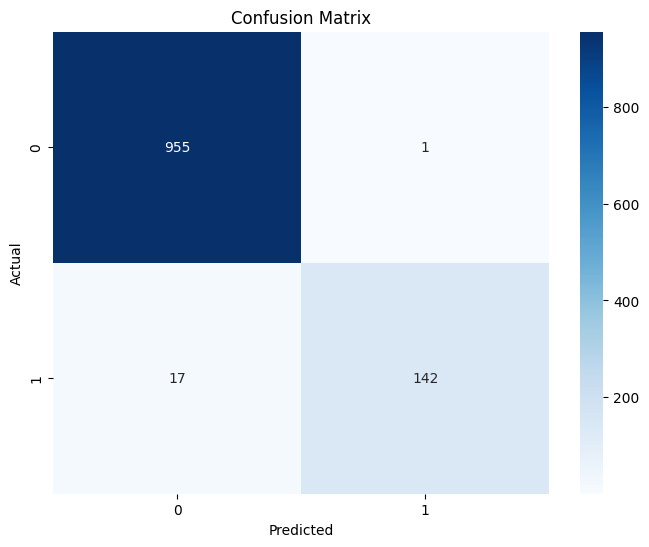

GRU Model: F1 Score: 0.9403973509933775, Precision: 0.993006993006993, Recall: 0.8930817610062893, Accuracy: 0.9838565022421525


In [13]:
## SimpleRNN model 
test_rnn_model(simple_rnn_model_, x_test, y_test)


In [ ]:
new_emails = [
    "Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/123456 to claim now.",
    "Hey, are we still on for the meeting tomorrow?",
    "Hey honey, what time are we meeting tonight?",
    "Dear Valued Customer,We have detected suspicious activity on your account. To prevent unauthorized access, please verify your information immediately by clicking the link below"
]

# Preprocess the new data
new_sequences = tokenizer.texts_to_sequences(new_emails)
new_padded = pad_sequences(new_sequences, maxlen=20)

# gru_model_
# simple_rnn_model_
# lstm_model_

# Make predictions
predictions_prob = gru_model_.predict(new_padded)  # Probabilities

predictions = [1 if prob > 0.5 else 0 for prob in predictions_prob]  # Binary classes

# Output the predictions
for email, prediction in zip(new_emails, predictions):
    print(f"Email: {email}")
    print(f"Prediction: {'Spam' if prediction == 1 else 'Not Spam'}\n")
    



# save the respective models
gru_model_.save('gru_model.h5')
simple_rnn_model_.save('simple_rnn_model.h5')
lstm_model_.save('lstm_model.h5')




In [ ]:
# plt confusion matrix


## Establishing benchmarks & comparing models

- since we have a random section of test and training data we need an average of 5 runs to determine the benchmark of that model

In [ ]:

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'embedding_dim': [50, 100, 200],
    'rnn_units': [32, 64, 128],
    'rnn_type': ['GRU'],
    'dropout': [0.2, 0.4],
    'optimizer': ['rmsprop', 'sgd'],
    'batch_size': [32, 64],
    'activation': ['relu', 'tanh'],
}

lstm_combinations = execute_grid_search(
    param_grid, x_train, y_train, x_test, y_test, num_words
)


In [ ]:

# print(lstm_combinations['table'].T)

# print(lstm_combinations['best_accuracy'], lstm_combinations['best_model_accuracy'])

In [ ]:
results = lstm_combinations['table']

results['accuracy'] = results['accuracy'].apply(lambda x: x[0] if isinstance(x, list) else x)


print(results[results['accuracy'] > 0.99])

filtered_df = results[results['accuracy'] > 0.987]